# Import

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR
import sys, os

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname("src"))))

from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer

# Setup

In [2]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Dataset parameters"""
BATCH = 128
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True

"""optimizer parameters"""
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"
OPTIMIZER = "SGD"
# OPTIMIZER = "SGD_nasterov"
# OPTIMIZER = "AdamW"
# OPTIMIZER = "AdamW_amsgrad"
# OPTIMIZER = "NAdam"

"""Learning rate scheduler parameters"""
NUM_EPOCHS = 100

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 100

file_name = f"MyResNet32_{BATCH}_{OPTIMIZER}"

In [3]:
file_name

'MyResNet32_128_SGD'

# Loading the dataset

## Define Dateloader

In [4]:
tmp = LoadDataset(root="../../../data", seceted_dataset=DATASET)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

/home/lee/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  50000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [5]:
train_dataloader, valid_dataloader, test_dataloader = tmp.get_dataloader(
    batch_size=BATCH, shuffle=SHUFFLE, num_workers=NUMOFWORKERS, pin_memory=PIN_MEMORY
)

train.transforms = Compose(
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
      ToTensor()
      Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[1, 1, 1], inplace=True)
) 128
test.transforms = ToTensor() 128


# Define ResNet

## Model Confirm

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
model = MyResNet_CIFAR(num_classes=COUNT_OF_CLASSES, num_layer_factor=5).to(device)

# Define Training

## (1) Define Criterion

In [8]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [9]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4
    )
elif OPTIMIZER == "SGD_nasterov":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4, nesterov=True
    )
elif OPTIMIZER == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "AdamW_amsgrad":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4, amsgrad=True)
elif OPTIMIZER == "NAdam":
    optimizer = torch.optim.NAdam(model.parameters(), weight_decay=1e-4)

## (3) Define Early Stopping

In [10]:
earlystopper = EarlyStopper(patience=EARLYSTOPPINGPATIENCE, model=model, file_name=file_name)

## (4) Define Learning Rate schedualer

In [11]:
scheduler = ExponentialLR(optimizer, gamma=0.95)

## (5) Define AMP scaler

In [12]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [13]:
if os.path.exists(file_name + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        file_name + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_name)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

File does not exist. Created a new log.


In [14]:
optimizer.param_groups[0]["lr"]

0.1

In [15]:
earlystopper.early_stop_counter

0

# [Training Loop]

In [16]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_name,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    
    
    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 1/100] :


1 Train: 100%|███████| 391/391 [00:35<00:00, 11.01it/s]

Train Loss: 2.4385 | Train Acc: 10.33%


Test  Loss: 2.2999 | Test Acc: 10.65%
updated best eval loss : 2.29991955696782
--------------------------------------------------
[Epoch 2/100] :


2 Train: 100%|███████| 391/391 [00:30<00:00, 13.02it/s]


Train Loss: 2.2826 | Train Acc: 11.88%
Test  Loss: 2.3711 | Test Acc: 12.05%
--------------------------------------------------
[Epoch 3/100] :


3 Train: 100%|███████| 391/391 [00:27<00:00, 14.07it/s]


Train Loss: 2.0645 | Train Acc: 21.78%
Test  Loss: 1.9125 | Test Acc: 27.42%
updated best eval loss : 1.9124599604666987
--------------------------------------------------
[Epoch 4/100] :


4 Train: 100%|███████| 391/391 [00:27<00:00, 14.01it/s]


Train Loss: 1.7676 | Train Acc: 34.56%
Test  Loss: 2.3067 | Test Acc: 26.66%
--------------------------------------------------
[Epoch 5/100] :


5 Train: 100%|███████| 391/391 [00:30<00:00, 12.79it/s]


Train Loss: 1.4857 | Train Acc: 46.54%
Test  Loss: 1.3883 | Test Acc: 49.22%
updated best eval loss : 1.3883048959925204
--------------------------------------------------
[Epoch 6/100] :


6 Train: 100%|███████| 391/391 [00:28<00:00, 13.53it/s]


Train Loss: 1.2398 | Train Acc: 55.84%
Test  Loss: 1.1620 | Test Acc: 59.64%
updated best eval loss : 1.162045938304708
--------------------------------------------------
[Epoch 7/100] :


7 Train: 100%|███████| 391/391 [00:29<00:00, 13.35it/s]


Train Loss: 1.0727 | Train Acc: 61.92%
Test  Loss: 1.2486 | Test Acc: 57.78%
--------------------------------------------------
[Epoch 8/100] :


8 Train: 100%|███████| 391/391 [00:29<00:00, 13.05it/s]


Train Loss: 0.9693 | Train Acc: 65.88%
Test  Loss: 0.8901 | Test Acc: 68.92%
updated best eval loss : 0.8901330496691451
--------------------------------------------------
[Epoch 9/100] :


9 Train: 100%|███████| 391/391 [00:32<00:00, 12.15it/s]


Train Loss: 0.8951 | Train Acc: 68.67%
Test  Loss: 1.0430 | Test Acc: 64.52%
--------------------------------------------------
[Epoch 10/100] :


10 Train: 100%|██████| 391/391 [00:43<00:00,  9.04it/s]


Train Loss: 0.8366 | Train Acc: 70.95%
Test  Loss: 0.8068 | Test Acc: 72.66%
updated best eval loss : 0.8067566646805292
--------------------------------------------------
[Epoch 11/100] :


11 Train: 100%|██████| 391/391 [00:47<00:00,  8.19it/s]


Train Loss: 0.7913 | Train Acc: 72.59%
Test  Loss: 0.8675 | Test Acc: 71.11%
--------------------------------------------------
[Epoch 12/100] :


12 Train: 100%|██████| 391/391 [00:37<00:00, 10.31it/s]


Train Loss: 0.7553 | Train Acc: 73.76%
Test  Loss: 0.9393 | Test Acc: 69.04%
--------------------------------------------------
[Epoch 13/100] :


13 Train: 100%|██████| 391/391 [00:34<00:00, 11.33it/s]


Train Loss: 0.7223 | Train Acc: 74.81%
Test  Loss: 0.8171 | Test Acc: 72.46%
--------------------------------------------------
[Epoch 14/100] :


14 Train: 100%|██████| 391/391 [00:33<00:00, 11.69it/s]


Train Loss: 0.7079 | Train Acc: 75.44%
Test  Loss: 0.7679 | Test Acc: 74.24%
updated best eval loss : 0.767948439981364
--------------------------------------------------
[Epoch 15/100] :


15 Train: 100%|██████| 391/391 [00:33<00:00, 11.63it/s]


Train Loss: 0.6811 | Train Acc: 76.22%
Test  Loss: 0.9673 | Test Acc: 68.46%
--------------------------------------------------
[Epoch 16/100] :


16 Train: 100%|██████| 391/391 [00:33<00:00, 11.62it/s]


Train Loss: 0.6587 | Train Acc: 77.14%
Test  Loss: 0.6471 | Test Acc: 78.48%
updated best eval loss : 0.6470602426347853
--------------------------------------------------
[Epoch 17/100] :


17 Train: 100%|██████| 391/391 [00:33<00:00, 11.51it/s]


Train Loss: 0.6427 | Train Acc: 77.70%
Test  Loss: 0.7345 | Test Acc: 75.97%
--------------------------------------------------
[Epoch 18/100] :


18 Train: 100%|██████| 391/391 [00:34<00:00, 11.32it/s]


Train Loss: 0.6333 | Train Acc: 77.84%
Test  Loss: 0.6485 | Test Acc: 77.69%
--------------------------------------------------
[Epoch 19/100] :


19 Train: 100%|██████| 391/391 [00:32<00:00, 11.96it/s]


Train Loss: 0.6211 | Train Acc: 78.43%
Test  Loss: 0.6480 | Test Acc: 78.91%
--------------------------------------------------
[Epoch 20/100] :


20 Train: 100%|██████| 391/391 [00:33<00:00, 11.64it/s]


Train Loss: 0.6108 | Train Acc: 78.75%
Test  Loss: 0.8449 | Test Acc: 73.01%
--------------------------------------------------
[Epoch 21/100] :


21 Train: 100%|██████| 391/391 [00:33<00:00, 11.56it/s]


Train Loss: 0.5970 | Train Acc: 79.31%
Test  Loss: 0.6307 | Test Acc: 78.35%
updated best eval loss : 0.6306547322605229
--------------------------------------------------
[Epoch 22/100] :


22 Train: 100%|██████| 391/391 [00:36<00:00, 10.69it/s]


Train Loss: 0.5781 | Train Acc: 79.93%
Test  Loss: 0.6656 | Test Acc: 77.03%
--------------------------------------------------
[Epoch 23/100] :


23 Train: 100%|██████| 391/391 [00:47<00:00,  8.31it/s]


Train Loss: 0.5746 | Train Acc: 79.93%
Test  Loss: 0.7198 | Test Acc: 75.24%
--------------------------------------------------
[Epoch 24/100] :


24 Train: 100%|██████| 391/391 [00:44<00:00,  8.71it/s]


Train Loss: 0.5721 | Train Acc: 80.07%
Test  Loss: 0.7588 | Test Acc: 74.60%
--------------------------------------------------
[Epoch 25/100] :


25 Train: 100%|██████| 391/391 [00:48<00:00,  8.10it/s]


Train Loss: 0.5633 | Train Acc: 80.45%
Test  Loss: 0.7870 | Test Acc: 75.40%
--------------------------------------------------
[Epoch 26/100] :


26 Train: 100%|██████| 391/391 [00:46<00:00,  8.37it/s]


Train Loss: 0.5519 | Train Acc: 80.92%
Test  Loss: 0.7323 | Test Acc: 76.25%
--------------------------------------------------
[Epoch 27/100] :


27 Train: 100%|██████| 391/391 [00:48<00:00,  8.05it/s]


Train Loss: 0.5462 | Train Acc: 80.96%
Test  Loss: 0.7061 | Test Acc: 75.88%
--------------------------------------------------
[Epoch 28/100] :


28 Train: 100%|██████| 391/391 [00:46<00:00,  8.39it/s]


Train Loss: 0.5440 | Train Acc: 81.16%
Test  Loss: 0.7973 | Test Acc: 74.07%
--------------------------------------------------
[Epoch 29/100] :


29 Train: 100%|██████| 391/391 [00:47<00:00,  8.19it/s]


Train Loss: 0.5315 | Train Acc: 81.56%
Test  Loss: 0.6475 | Test Acc: 78.97%
--------------------------------------------------
[Epoch 30/100] :


30 Train: 100%|██████| 391/391 [00:47<00:00,  8.26it/s]


Train Loss: 0.5268 | Train Acc: 81.77%
Test  Loss: 0.8078 | Test Acc: 73.76%
--------------------------------------------------
[Epoch 31/100] :


31 Train: 100%|██████| 391/391 [00:46<00:00,  8.40it/s]


Train Loss: 0.5221 | Train Acc: 81.84%
Test  Loss: 0.6839 | Test Acc: 76.91%
--------------------------------------------------
[Epoch 32/100] :


32 Train: 100%|██████| 391/391 [00:46<00:00,  8.42it/s]


Train Loss: 0.5148 | Train Acc: 82.30%
Test  Loss: 0.6296 | Test Acc: 78.29%
updated best eval loss : 0.6295605282994765
--------------------------------------------------
[Epoch 33/100] :


33 Train: 100%|██████| 391/391 [00:48<00:00,  8.07it/s]


Train Loss: 0.5117 | Train Acc: 82.28%
Test  Loss: 0.6601 | Test Acc: 78.08%
--------------------------------------------------
[Epoch 34/100] :


34 Train: 100%|██████| 391/391 [00:45<00:00,  8.55it/s]


Train Loss: 0.5023 | Train Acc: 82.53%
Test  Loss: 0.8049 | Test Acc: 73.98%
--------------------------------------------------
[Epoch 35/100] :


35 Train: 100%|██████| 391/391 [00:48<00:00,  8.06it/s]


Train Loss: 0.5007 | Train Acc: 82.54%
Test  Loss: 0.6773 | Test Acc: 77.85%
--------------------------------------------------
[Epoch 36/100] :


36 Train: 100%|██████| 391/391 [00:45<00:00,  8.52it/s]


Train Loss: 0.4968 | Train Acc: 82.86%
Test  Loss: 0.6657 | Test Acc: 78.53%
--------------------------------------------------
[Epoch 37/100] :


37 Train: 100%|██████| 391/391 [00:46<00:00,  8.39it/s]


Train Loss: 0.4918 | Train Acc: 82.90%
Test  Loss: 0.5965 | Test Acc: 80.02%
updated best eval loss : 0.5965393155435973
--------------------------------------------------
[Epoch 38/100] :


38 Train: 100%|██████| 391/391 [00:45<00:00,  8.59it/s]


Train Loss: 0.4882 | Train Acc: 83.20%
Test  Loss: 0.7852 | Test Acc: 74.76%
--------------------------------------------------
[Epoch 39/100] :


39 Train: 100%|██████| 391/391 [00:46<00:00,  8.35it/s]


Train Loss: 0.4827 | Train Acc: 83.14%
Test  Loss: 0.5180 | Test Acc: 83.02%
updated best eval loss : 0.5180227311351632
--------------------------------------------------
[Epoch 40/100] :


40 Train: 100%|██████| 391/391 [00:46<00:00,  8.36it/s]


Train Loss: 0.4812 | Train Acc: 83.29%
Test  Loss: 0.7283 | Test Acc: 76.81%
--------------------------------------------------
[Epoch 41/100] :


41 Train: 100%|██████| 391/391 [00:48<00:00,  8.00it/s]


Train Loss: 0.4814 | Train Acc: 83.31%
Test  Loss: 0.7017 | Test Acc: 78.41%
--------------------------------------------------
[Epoch 42/100] :


42 Train: 100%|██████| 391/391 [00:46<00:00,  8.47it/s]


Train Loss: 0.4812 | Train Acc: 83.27%
Test  Loss: 0.5959 | Test Acc: 79.31%
--------------------------------------------------
[Epoch 43/100] :


43 Train: 100%|██████| 391/391 [00:47<00:00,  8.21it/s]


Train Loss: 0.4718 | Train Acc: 83.56%
Test  Loss: 0.5876 | Test Acc: 80.07%
--------------------------------------------------
[Epoch 44/100] :


44 Train: 100%|██████| 391/391 [00:46<00:00,  8.37it/s]


Train Loss: 0.4706 | Train Acc: 83.62%
Test  Loss: 0.5121 | Test Acc: 82.37%
updated best eval loss : 0.5120775190335286
--------------------------------------------------
[Epoch 45/100] :


45 Train: 100%|██████| 391/391 [00:47<00:00,  8.17it/s]


Train Loss: 0.4624 | Train Acc: 83.96%
Test  Loss: 0.6135 | Test Acc: 79.91%
--------------------------------------------------
[Epoch 46/100] :


46 Train: 100%|██████| 391/391 [00:46<00:00,  8.39it/s]


Train Loss: 0.4720 | Train Acc: 83.66%
Test  Loss: 0.6318 | Test Acc: 78.38%
--------------------------------------------------
[Epoch 47/100] :


47 Train: 100%|██████| 391/391 [00:46<00:00,  8.38it/s]


Train Loss: 0.4626 | Train Acc: 83.80%
Test  Loss: 0.4930 | Test Acc: 83.35%
updated best eval loss : 0.49297843024700505
--------------------------------------------------
[Epoch 48/100] :


48 Train: 100%|██████| 391/391 [00:46<00:00,  8.34it/s]


Train Loss: 0.4632 | Train Acc: 83.92%
Test  Loss: 0.5737 | Test Acc: 81.66%
--------------------------------------------------
[Epoch 49/100] :


49 Train: 100%|██████| 391/391 [00:46<00:00,  8.35it/s]


Train Loss: 0.4561 | Train Acc: 84.08%
Test  Loss: 0.7687 | Test Acc: 76.27%
--------------------------------------------------
[Epoch 50/100] :


50 Train: 100%|██████| 391/391 [00:47<00:00,  8.22it/s]


Train Loss: 0.4603 | Train Acc: 83.93%
Test  Loss: 0.5833 | Test Acc: 79.59%
--------------------------------------------------
[Epoch 51/100] :


51 Train: 100%|██████| 391/391 [00:45<00:00,  8.56it/s]


Train Loss: 0.4517 | Train Acc: 84.28%
Test  Loss: 0.5110 | Test Acc: 83.23%
--------------------------------------------------
[Epoch 52/100] :


52 Train: 100%|██████| 391/391 [00:46<00:00,  8.45it/s]


Train Loss: 0.4491 | Train Acc: 84.37%
Test  Loss: 0.5906 | Test Acc: 80.72%
--------------------------------------------------
[Epoch 53/100] :


53 Train: 100%|██████| 391/391 [00:46<00:00,  8.44it/s]


Train Loss: 0.4451 | Train Acc: 84.48%
Test  Loss: 0.4899 | Test Acc: 83.90%
updated best eval loss : 0.48991296789314176
--------------------------------------------------
[Epoch 54/100] :


54 Train: 100%|██████| 391/391 [00:49<00:00,  7.98it/s]


Train Loss: 0.4466 | Train Acc: 84.52%
Test  Loss: 0.5088 | Test Acc: 82.73%
--------------------------------------------------
[Epoch 55/100] :


55 Train: 100%|██████| 391/391 [00:44<00:00,  8.69it/s]


Train Loss: 0.4424 | Train Acc: 84.41%
Test  Loss: 0.5521 | Test Acc: 81.86%
--------------------------------------------------
[Epoch 56/100] :


56 Train: 100%|██████| 391/391 [00:47<00:00,  8.26it/s]


Train Loss: 0.4496 | Train Acc: 84.35%
Test  Loss: 0.4885 | Test Acc: 83.39%
updated best eval loss : 0.4885250405420231
--------------------------------------------------
[Epoch 57/100] :


57 Train: 100%|██████| 391/391 [00:46<00:00,  8.47it/s]


Train Loss: 0.4416 | Train Acc: 84.66%
Test  Loss: 0.5765 | Test Acc: 80.48%
--------------------------------------------------
[Epoch 58/100] :


58 Train: 100%|██████| 391/391 [00:47<00:00,  8.24it/s]


Train Loss: 0.4382 | Train Acc: 84.74%
Test  Loss: 0.7487 | Test Acc: 75.07%
--------------------------------------------------
[Epoch 59/100] :


59 Train: 100%|██████| 391/391 [00:46<00:00,  8.41it/s]


Train Loss: 0.4384 | Train Acc: 84.62%
Test  Loss: 0.6322 | Test Acc: 79.12%
--------------------------------------------------
[Epoch 60/100] :


60 Train: 100%|██████| 391/391 [00:46<00:00,  8.39it/s]


Train Loss: 0.4340 | Train Acc: 84.84%
Test  Loss: 0.4601 | Test Acc: 84.63%
updated best eval loss : 0.46014485932603666
--------------------------------------------------
[Epoch 61/100] :


61 Train: 100%|██████| 391/391 [00:46<00:00,  8.50it/s]


Train Loss: 0.4420 | Train Acc: 84.77%
Test  Loss: 0.5416 | Test Acc: 82.04%
--------------------------------------------------
[Epoch 62/100] :


62 Train: 100%|██████| 391/391 [00:47<00:00,  8.26it/s]


Train Loss: 0.4297 | Train Acc: 85.01%
Test  Loss: 0.5495 | Test Acc: 81.93%
--------------------------------------------------
[Epoch 63/100] :


63 Train: 100%|██████| 391/391 [00:46<00:00,  8.39it/s]


Train Loss: 0.4301 | Train Acc: 85.10%
Test  Loss: 0.6406 | Test Acc: 78.58%
--------------------------------------------------
[Epoch 64/100] :


64 Train: 100%|██████| 391/391 [00:48<00:00,  8.04it/s]


Train Loss: 0.4337 | Train Acc: 84.81%
Test  Loss: 0.5651 | Test Acc: 81.63%
--------------------------------------------------
[Epoch 65/100] :


65 Train: 100%|██████| 391/391 [00:46<00:00,  8.35it/s]


Train Loss: 0.4246 | Train Acc: 85.22%
Test  Loss: 0.6931 | Test Acc: 78.88%
--------------------------------------------------
[Epoch 66/100] :


66 Train: 100%|██████| 391/391 [00:47<00:00,  8.22it/s]


Train Loss: 0.4330 | Train Acc: 84.97%
Test  Loss: 0.6178 | Test Acc: 80.50%
--------------------------------------------------
[Epoch 67/100] :


67 Train: 100%|██████| 391/391 [00:47<00:00,  8.26it/s]


Train Loss: 0.4328 | Train Acc: 84.97%
Test  Loss: 0.5199 | Test Acc: 82.82%
--------------------------------------------------
[Epoch 68/100] :


68 Train: 100%|██████| 391/391 [00:47<00:00,  8.21it/s]


Train Loss: 0.4237 | Train Acc: 85.10%
Test  Loss: 0.6312 | Test Acc: 78.44%
--------------------------------------------------
[Epoch 69/100] :


69 Train: 100%|██████| 391/391 [00:47<00:00,  8.31it/s]


Train Loss: 0.4245 | Train Acc: 85.18%
Test  Loss: 0.5469 | Test Acc: 82.38%
--------------------------------------------------
[Epoch 70/100] :


70 Train: 100%|██████| 391/391 [00:47<00:00,  8.16it/s]


Train Loss: 0.4189 | Train Acc: 85.34%
Test  Loss: 0.6511 | Test Acc: 77.78%
--------------------------------------------------
[Epoch 71/100] :


71 Train: 100%|██████| 391/391 [00:46<00:00,  8.33it/s]


Train Loss: 0.4272 | Train Acc: 85.01%
Test  Loss: 0.6250 | Test Acc: 80.49%
--------------------------------------------------
[Epoch 72/100] :


72 Train: 100%|██████| 391/391 [00:47<00:00,  8.32it/s]


Train Loss: 0.4222 | Train Acc: 85.38%
Test  Loss: 0.5941 | Test Acc: 80.23%
--------------------------------------------------
[Epoch 73/100] :


73 Train: 100%|██████| 391/391 [00:47<00:00,  8.23it/s]


Train Loss: 0.4196 | Train Acc: 85.53%
Test  Loss: 0.5873 | Test Acc: 80.57%
--------------------------------------------------
[Epoch 74/100] :


74 Train: 100%|██████| 391/391 [00:46<00:00,  8.44it/s]


Train Loss: 0.4194 | Train Acc: 85.34%
Test  Loss: 0.6466 | Test Acc: 78.49%
--------------------------------------------------
[Epoch 75/100] :


75 Train: 100%|██████| 391/391 [00:48<00:00,  8.09it/s]


Train Loss: 0.4161 | Train Acc: 85.52%
Test  Loss: 0.7901 | Test Acc: 75.21%
--------------------------------------------------
[Epoch 76/100] :


76 Train: 100%|██████| 391/391 [00:46<00:00,  8.36it/s]


Train Loss: 0.4179 | Train Acc: 85.42%
Test  Loss: 0.5885 | Test Acc: 80.77%
--------------------------------------------------
[Epoch 77/100] :


77 Train: 100%|██████| 391/391 [00:47<00:00,  8.24it/s]


Train Loss: 0.4190 | Train Acc: 85.46%
Test  Loss: 0.5166 | Test Acc: 82.37%
--------------------------------------------------
[Epoch 78/100] :


78 Train: 100%|██████| 391/391 [00:46<00:00,  8.40it/s]


Train Loss: 0.4214 | Train Acc: 85.39%
Test  Loss: 0.6998 | Test Acc: 77.84%
--------------------------------------------------
[Epoch 79/100] :


79 Train: 100%|██████| 391/391 [00:46<00:00,  8.36it/s]


Train Loss: 0.4102 | Train Acc: 85.72%
Test  Loss: 0.7083 | Test Acc: 76.49%
--------------------------------------------------
[Epoch 80/100] :


80 Train: 100%|██████| 391/391 [00:45<00:00,  8.56it/s]


Train Loss: 0.4098 | Train Acc: 85.77%
Test  Loss: 0.5793 | Test Acc: 81.37%
--------------------------------------------------
[Epoch 81/100] :


81 Train: 100%|██████| 391/391 [00:45<00:00,  8.51it/s]


Train Loss: 0.4220 | Train Acc: 85.38%
Test  Loss: 0.4562 | Test Acc: 84.54%
updated best eval loss : 0.4561629336846026
--------------------------------------------------
[Epoch 82/100] :


82 Train: 100%|██████| 391/391 [00:46<00:00,  8.37it/s]


Train Loss: 0.4075 | Train Acc: 85.85%
Test  Loss: 0.6128 | Test Acc: 80.22%
--------------------------------------------------
[Epoch 83/100] :


83 Train: 100%|██████| 391/391 [00:48<00:00,  8.03it/s]


Train Loss: 0.4147 | Train Acc: 85.54%
Test  Loss: 0.5636 | Test Acc: 81.08%
--------------------------------------------------
[Epoch 84/100] :


84 Train: 100%|██████| 391/391 [00:45<00:00,  8.55it/s]


Train Loss: 0.4116 | Train Acc: 85.72%
Test  Loss: 0.5369 | Test Acc: 82.09%
--------------------------------------------------
[Epoch 85/100] :


85 Train: 100%|██████| 391/391 [00:47<00:00,  8.16it/s]


Train Loss: 0.4147 | Train Acc: 85.65%
Test  Loss: 0.5413 | Test Acc: 82.29%
--------------------------------------------------
[Epoch 86/100] :


86 Train: 100%|██████| 391/391 [00:46<00:00,  8.36it/s]


Train Loss: 0.4033 | Train Acc: 85.99%
Test  Loss: 0.5206 | Test Acc: 82.50%
--------------------------------------------------
[Epoch 87/100] :


87 Train: 100%|██████| 391/391 [00:47<00:00,  8.22it/s]


Train Loss: 0.4081 | Train Acc: 85.87%
Test  Loss: 0.5945 | Test Acc: 80.24%
--------------------------------------------------
[Epoch 88/100] :


88 Train: 100%|██████| 391/391 [00:47<00:00,  8.19it/s]


Train Loss: 0.4049 | Train Acc: 85.98%
Test  Loss: 0.6363 | Test Acc: 80.00%
--------------------------------------------------
[Epoch 89/100] :


89 Train: 100%|██████| 391/391 [00:47<00:00,  8.26it/s]


Train Loss: 0.4116 | Train Acc: 85.77%
Test  Loss: 0.5735 | Test Acc: 80.29%
--------------------------------------------------
[Epoch 90/100] :


90 Train: 100%|██████| 391/391 [00:46<00:00,  8.38it/s]


Train Loss: 0.4097 | Train Acc: 85.75%
Test  Loss: 0.4730 | Test Acc: 84.39%
--------------------------------------------------
[Epoch 91/100] :


91 Train: 100%|██████| 391/391 [00:47<00:00,  8.27it/s]


Train Loss: 0.4015 | Train Acc: 86.02%
Test  Loss: 0.5799 | Test Acc: 81.33%
--------------------------------------------------
[Epoch 92/100] :


92 Train: 100%|██████| 391/391 [00:48<00:00,  8.11it/s]


Train Loss: 0.4022 | Train Acc: 85.93%
Test  Loss: 0.5878 | Test Acc: 79.97%
--------------------------------------------------
[Epoch 93/100] :


93 Train: 100%|██████| 391/391 [00:47<00:00,  8.18it/s]


Train Loss: 0.4001 | Train Acc: 85.98%
Test  Loss: 0.5841 | Test Acc: 80.95%
--------------------------------------------------
[Epoch 94/100] :


94 Train: 100%|██████| 391/391 [00:46<00:00,  8.36it/s]


Train Loss: 0.3995 | Train Acc: 86.04%
Test  Loss: 0.6241 | Test Acc: 80.58%
--------------------------------------------------
[Epoch 95/100] :


95 Train: 100%|██████| 391/391 [00:47<00:00,  8.25it/s]


Train Loss: 0.4003 | Train Acc: 86.04%
Test  Loss: 0.8099 | Test Acc: 74.19%
--------------------------------------------------
[Epoch 96/100] :


96 Train: 100%|██████| 391/391 [00:47<00:00,  8.24it/s]


Train Loss: 0.4019 | Train Acc: 86.05%
Test  Loss: 0.5587 | Test Acc: 81.49%
--------------------------------------------------
[Epoch 97/100] :


97 Train: 100%|██████| 391/391 [00:47<00:00,  8.23it/s]


Train Loss: 0.4004 | Train Acc: 86.03%
Test  Loss: 0.6350 | Test Acc: 79.28%
--------------------------------------------------
[Epoch 98/100] :


98 Train: 100%|██████| 391/391 [00:48<00:00,  8.07it/s]


Train Loss: 0.4011 | Train Acc: 85.98%
Test  Loss: 0.4989 | Test Acc: 83.87%
--------------------------------------------------
[Epoch 99/100] :


99 Train: 100%|██████| 391/391 [00:48<00:00,  8.13it/s]


Train Loss: 0.3981 | Train Acc: 86.09%
Test  Loss: 0.5514 | Test Acc: 81.77%
--------------------------------------------------
[Epoch 100/100] :


100 Train: 100%|█████| 391/391 [00:47<00:00,  8.17it/s]


Train Loss: 0.4038 | Train Acc: 85.93%
Test  Loss: 0.6268 | Test Acc: 79.28%
--------------------------------------------------


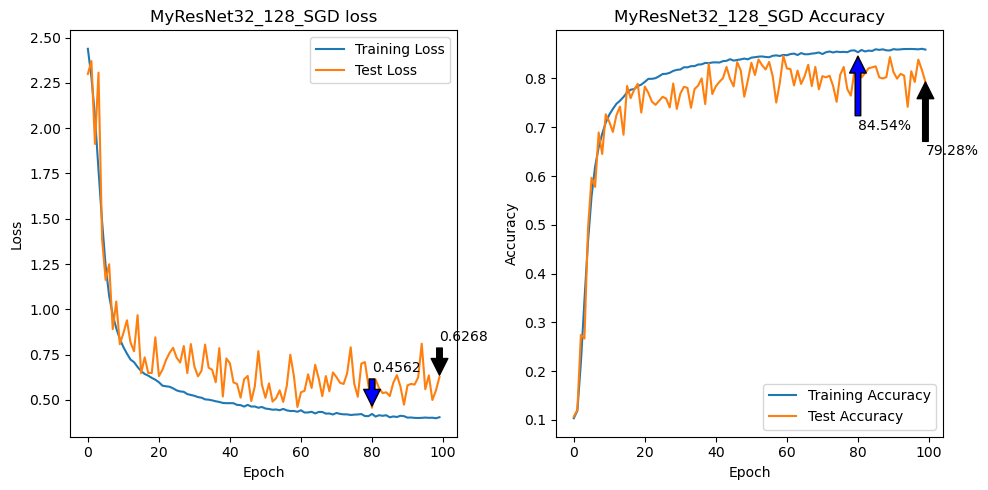

In [17]:
view = LogViewer(logs)
view.draw(save_name=file_name)

In [18]:
view.print_all()

1 epoch: train_loss=2.4385, train_acc=0.1033, test_loss=2.2999, test_acc=0.1065, lr=0.1000
2 epoch: train_loss=2.2826, train_acc=0.1188, test_loss=2.3711, test_acc=0.1205, lr=0.1000
3 epoch: train_loss=2.0645, train_acc=0.2178, test_loss=1.9125, test_acc=0.2742, lr=0.1000
4 epoch: train_loss=1.7676, train_acc=0.3456, test_loss=2.3067, test_acc=0.2666, lr=0.1000
5 epoch: train_loss=1.4857, train_acc=0.4654, test_loss=1.3883, test_acc=0.4922, lr=0.1000
6 epoch: train_loss=1.2398, train_acc=0.5584, test_loss=1.1620, test_acc=0.5964, lr=0.1000
7 epoch: train_loss=1.0727, train_acc=0.6192, test_loss=1.2486, test_acc=0.5778, lr=0.1000
8 epoch: train_loss=0.9693, train_acc=0.6588, test_loss=0.8901, test_acc=0.6892, lr=0.1000
9 epoch: train_loss=0.8951, train_acc=0.6867, test_loss=1.0430, test_acc=0.6452, lr=0.1000
10 epoch: train_loss=0.8366, train_acc=0.7095, test_loss=0.8068, test_acc=0.7266, lr=0.1000
11 epoch: train_loss=0.7913, train_acc=0.7259, test_loss=0.8675, test_acc=0.7111, lr=0.10